# Covid-19 Lung CT Scans

## Group Member
## Deepansh Suhane - 500201397
## Jaswinder Singh - 500195345
## Muhammad Ahmer - 500196858 
## Nikhil Nikhare - 500197137
## Harkirat Singh - 500200369
## Kashveer Randhawa - 500198472

In [1]:
pip install tabulate


[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Importing all the required libraries

In [2]:
import pandas as pd
from pathlib import Path
import os
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt, image as img
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import (
    Conv2D,
    Conv2DTranspose,
    MaxPool2D,
    ReLU,
    Flatten,
    Dense,
    UpSampling2D,
)
from tensorflow.keras.models import Model, Sequential
from skimage.transform import resize
from tensorflow import Tensor
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input
from tensorflow import Tensor
from scipy.stats import mannwhitneyu
from tabulate import tabulate

!pip install progressbar
import progressbar

# random seed generator
np.random.seed(3)
tf.random.set_seed(7)

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12067 sha256=d3d0c68450290d63353a1ff394e3c0a4384ded504f2d259e13f45808df7cb4ec
  Stored in directory: c:\users\gurje\appdata\local\pip\cache\wheels\d7\d9\89\a3f31c76ff6d51dc3b1575628f59afe59e4ceae3f2748cd7ad
Successfully built progressbar

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Importing dataset

In [3]:

def load_raw_data():
     
     # Insert respective path to covid and no-covid images
    covid_path = "C:\\Users\\gurje\\Downloads\\2COVID-20221210T235921Z-001\\2COVID"
    non_covid_path = "C:\\Users\\gurje\\Downloads\\1NonCOVID-20221210T235917Z-001\\1NonCOVID"

    covid_images = list(Path(covid_path).glob("*.png"))
    non_covid_images = list(Path(non_covid_path).glob("*.png"))

    # To visualize the dataset
    fig = plt.figure(figsize=(10, 10))
    fig.add_subplot(1, 2, 1)
    image = img.imread(covid_images[1])
    plt.imshow(image)
    plt.title("CT Scan of Covid Affected Lungs")

    fig.add_subplot(1, 2, 2)
    image = img.imread(non_covid_images[1])
    plt.imshow(image)
    plt.title("CT Scan of Healthy Lungs")
    return covid_images, non_covid_images


## Converting image into .npy numpy arrayas

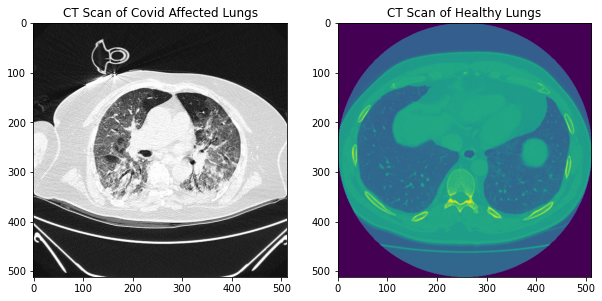

In [4]:

# To convert .png image files to .npy numpy arrays

covid_images, non_covid_images = load_raw_data()
IMG_SIZE = 128

# Two empty numpy arrays to store coverted images
positive_npy = np.empty((len(covid_images), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
negative_npy = np.empty((len(non_covid_images), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)

# start a bar of show percentage of loading data 
covid_bar = progressbar.ProgressBar(maxval=len(covid_images), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
non_covid_bar = progressbar.ProgressBar(maxval=len(non_covid_images), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])


In [5]:
covid_bar.start()
# Converting COVID dataset to .npy format
for i, _file in enumerate(covid_images):
    try:
        image_npy = img.imread(_file)
        positive = resize(image_npy, (IMG_SIZE, IMG_SIZE, 1), anti_aliasing=True)
        positive_npy[i] = positive
    except:
        pass
    covid_bar.update(i+1)
    
covid_bar.finish()
print("COVID images converting done")

COVID images converting done


In [6]:

non_covid_bar.start()
# Converting non-COVID dataset to .npy format
for i, _file in enumerate(non_covid_images):
    try:
        image_npy = img.imread(_file)
        negative = resize(image_npy, (IMG_SIZE, IMG_SIZE, 1), anti_aliasing=True)
        negative_npy[i] = negative
    except:
        print("cant open image " + i + "th") 
        
    non_covid_bar.update(i+1)
non_covid_bar.finish()
print("non covid images converting done")

non covid images converting done


In [7]:
print(positive_npy.shape)
print(negative_npy.shape)


(7593, 128, 128, 1)
(6893, 128, 128, 1)


## Joining datasets

In [8]:
# To load dataset and concat them to x and y
def load_data():
    positive = positive_npy
    positive_labels = ["1" for i in positive]
    negative = negative_npy
    negative_labels = ["0" for i in negative]

    # Joining both datasets and labels
    X = np.concatenate([positive, negative])
    y = np.array((positive_labels + negative_labels), dtype=np.float32)
    return X, y

## Defining model

In [9]:

# CNN model
def cnn():
    model = Sequential()
    # convulutional layer
    model.add(Conv2D(32,kernel_size=5,activation="relu", input_shape=(128, 128, 1) ) )
    # Normalising after activation
    model.add(BatchNormalization())    
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=5, activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=5, activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(256, kernel_size=5, activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    # fully connected layer
    model.add(Dense(200, activation="relu"))
    # output
    model.add(Dense(2, activation="softmax"))
    model.compile(
        loss=keras.losses.sparse_categorical_crossentropy,
        optimizer= keras.optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0),
        metrics=["accuracy"],
    )
    return model

## Shape of a data set

In [10]:
X, y = load_data()
print(X.shape)
print(y.shape)

(14486, 128, 128, 1)
(14486,)


## Summary

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = cnn()

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 124, 124, 32)      832       
_________________________________________________________________
batch_normalization_4 (Batch (None, 124, 124, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 58, 58, 64)        51264     
_________________________________________________________________
batch_normalization_5 (Batch (None, 58, 58, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 25, 128)      

## Fitting model

In [13]:
history_cnn = model.fit(
    X_train,
    y_train,
    epochs=20,
    workers=4,
    validation_data=(X_test, y_test),
)

Epoch 1/20
363/363 [==============================] - 448s 1s/step - loss: 0.3654 - accuracy: 0.8518 - val_loss: 1.1431 - val_accuracy: 0.4758
Epoch 2/20
363/363 [==============================] - 437s 1s/step - loss: 0.2156 - accuracy: 0.9158 - val_loss: 0.3102 - val_accuracy: 0.8972
Epoch 3/20
363/363 [==============================] - 439s 1s/step - loss: 0.1545 - accuracy: 0.9399 - val_loss: 0.1425 - val_accuracy: 0.9438
Epoch 4/20
363/363 [==============================] - 445s 1s/step - loss: 0.1147 - accuracy: 0.9533 - val_loss: 0.1742 - val_accuracy: 0.9268
Epoch 5/20
363/363 [==============================] - 421s 1s/step - loss: 0.0856 - accuracy: 0.9675 - val_loss: 0.1051 - val_accuracy: 0.9624
Epoch 6/20
363/363 [==============================] - 403s 1s/step - loss: 0.0557 - accuracy: 0.9799 - val_loss: 0.1047 - val_accuracy: 0.9638
Epoch 7/20
363/363 [==============================] - 409s 1s/step - loss: 0.0457 - accuracy: 0.9848 - val_loss: 0.1355 - val_accuracy: 0.9551

In [14]:
# insert the path for the model to be saved
model.save('C:\\Users\\gurje\\Downloads\\covid')

INFO:tensorflow:Assets written to: C:\Users\gurje\Downloads\covid\assets


## Performing prediction

In [15]:
y_pred = model.predict(X_test)
predicted = np.argmax(y_pred, axis=-1)
accuracy = np.equal(y_test, predicted).mean()
print("Accuracy:", accuracy)

Accuracy: 0.9837819185645272


In [17]:
from tensorflow import keras
model = keras.models.load_model('C:\\Users\\gurje\\Downloads\\covid')

## Generating classification report

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1377
         1.0       0.99      0.98      0.98      1521

    accuracy                           0.98      2898
   macro avg       0.98      0.98      0.98      2898
weighted avg       0.98      0.98      0.98      2898



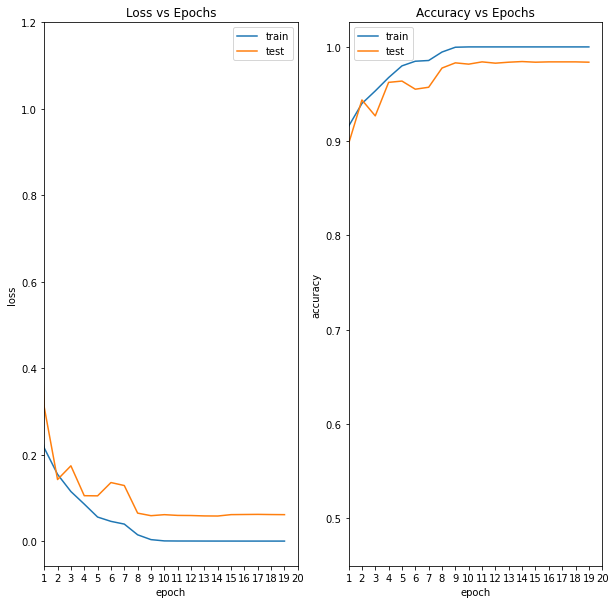

In [19]:
# To plot learning curves
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].set_title("Loss vs Epochs")
ax[0].plot(history_cnn.history["loss"])
ax[0].plot(history_cnn.history["val_loss"])
ax[0].legend(["train", "test"])
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")
ax[0].set_xlim(1, 20)
ax[0].set_xticks(range(1, 21))

ax[1].set_title("Accuracy vs Epochs")
ax[1].plot(history_cnn.history["accuracy"])
ax[1].plot(history_cnn.history["val_accuracy"])
ax[1].legend(["train", "test"])
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")
ax[1].set_xlim(1, 20)
ax[1].set_xticks(range(1, 21))

plt.show()

## Final report

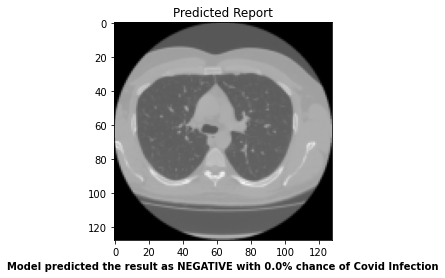

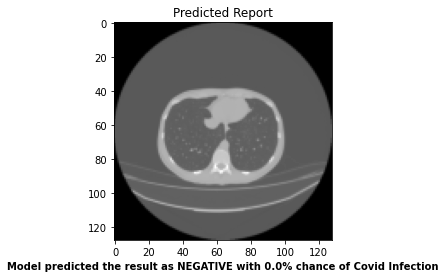

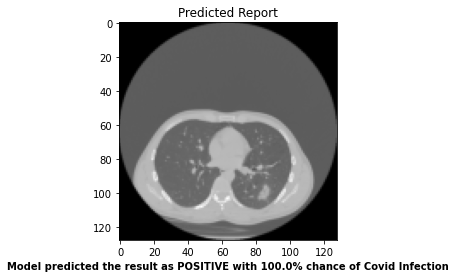

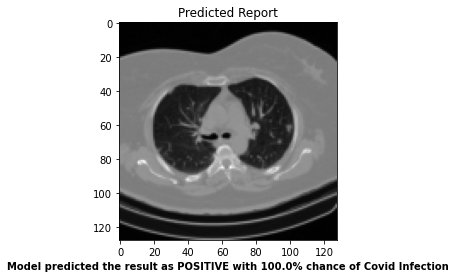

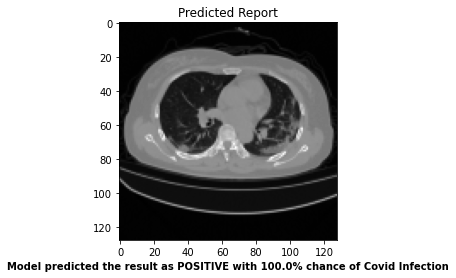

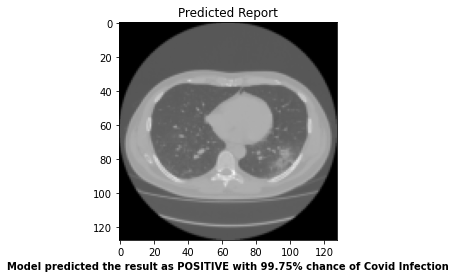

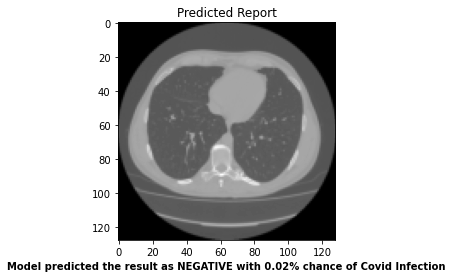

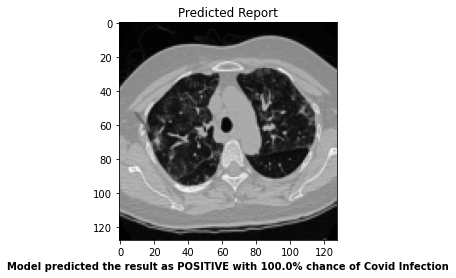

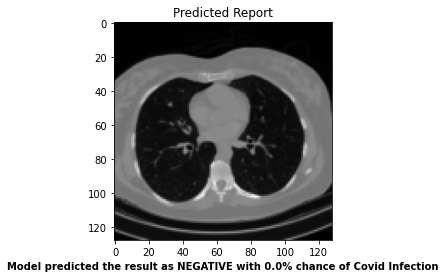

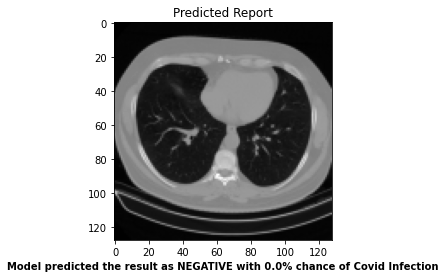

In [20]:
# To print the final report
j = 0
k = 0
for i, label in enumerate(y_pred):

    # Report for positive predicted cases
    if (np.argmax(y_pred[i]) == 1.0) and (j < 5):
        plt.title("Predicted Report")
        plt.imshow(X_test[i].squeeze(), cmap="gray")
        plt.xlabel(
            "Model predicted the result as POSITIVE with "
            + str(round((np.max(label) * 100), 2))
            + "% chance of Covid Infection",
            fontweight="bold",
        )

        plt.show()
        j = j + 1

    # Report for negative predicted cases
    if (np.argmax(y_pred[i]) == 0.0) and (k < 5):
        plt.title("Predicted Report")
        plt.imshow(X_test[i].squeeze(), cmap="gray")
        plt.xlabel(
            "Model predicted the result as NEGATIVE with "
            + str(round((np.min(label) * 100), 2))
            + "% chance of Covid Infection",
            fontweight="bold",
        )
        plt.show()
        k = k + 1

## End of assignment